# Loop 59 Analysis: Understanding the CV-LB Gap and Path Forward

## Key Questions:
1. Why did Spange-only (exp_058) perform 37.5% worse than best CV?
2. What is the true CV-LB relationship?
3. What approaches haven't been tried that could reduce the gap?
4. What is the path to reaching target 0.0347?

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Submission history
submissions = [
    {'exp': 'exp_000', 'cv': 0.0111, 'lb': 0.0982, 'name': 'Baseline MLP (Spange only)'},
    {'exp': 'exp_001', 'cv': 0.0123, 'lb': 0.1065, 'name': 'LightGBM'},
    {'exp': 'exp_003', 'cv': 0.0105, 'lb': 0.0972, 'name': 'Combined Spange+DRFP'},
    {'exp': 'exp_005', 'cv': 0.0104, 'lb': 0.0969, 'name': 'Large Ensemble'},
    {'exp': 'exp_006', 'cv': 0.0097, 'lb': 0.0946, 'name': 'Simpler Model'},
    {'exp': 'exp_007', 'cv': 0.0093, 'lb': 0.0932, 'name': 'Even Simpler'},
    {'exp': 'exp_009', 'cv': 0.0092, 'lb': 0.0936, 'name': 'Ridge Regression'},
    {'exp': 'exp_012', 'cv': 0.0090, 'lb': 0.0913, 'name': 'Simple Ensemble'},
    {'exp': 'exp_024', 'cv': 0.0087, 'lb': 0.0893, 'name': 'ACS PCA Fixed'},
    {'exp': 'exp_026', 'cv': 0.0085, 'lb': 0.0887, 'name': 'Weighted Loss'},
    {'exp': 'exp_030', 'cv': 0.0083, 'lb': 0.0877, 'name': 'GP Ensemble'},
    {'exp': 'exp_041', 'cv': 0.0090, 'lb': 0.0932, 'name': 'Aggressive Regularization'},
    {'exp': 'exp_042', 'cv': 0.0145, 'lb': 0.1147, 'name': 'GroupKFold CV'},
]

df = pd.DataFrame(submissions)
print('=== Submission History ===')
print(df.to_string(index=False))

=== Submission History ===
    exp     cv     lb                       name
exp_000 0.0111 0.0982 Baseline MLP (Spange only)
exp_001 0.0123 0.1065                   LightGBM
exp_003 0.0105 0.0972       Combined Spange+DRFP
exp_005 0.0104 0.0969             Large Ensemble
exp_006 0.0097 0.0946              Simpler Model
exp_007 0.0093 0.0932               Even Simpler
exp_009 0.0092 0.0936           Ridge Regression
exp_012 0.0090 0.0913            Simple Ensemble
exp_024 0.0087 0.0893              ACS PCA Fixed
exp_026 0.0085 0.0887              Weighted Loss
exp_030 0.0083 0.0877                GP Ensemble
exp_041 0.0090 0.0932  Aggressive Regularization
exp_042 0.0145 0.1147              GroupKFold CV


In [2]:
# Analyze CV-LB relationship
from scipy import stats

cv = df['cv'].values
lb = df['lb'].values

slope, intercept, r_value, p_value, std_err = stats.linregress(cv, lb)

print(f'\n=== CV-LB Relationship ===')
print(f'LB = {slope:.4f} * CV + {intercept:.4f}')
print(f'R² = {r_value**2:.4f}')
print(f'\nInterpretation:')
print(f'- Intercept: {intercept:.4f}')
print(f'- Target: 0.0347')
print(f'- Gap: {intercept - 0.0347:.4f} ({(intercept - 0.0347)/0.0347*100:.1f}% above target)')
print(f'\nTo reach target 0.0347:')
required_cv = (0.0347 - intercept) / slope
print(f'- Required CV: {required_cv:.6f}')
if required_cv < 0:
    print(f'- IMPOSSIBLE: Required CV is negative!')
    print(f'- Even with CV=0, predicted LB would be {intercept:.4f}')


=== CV-LB Relationship ===
LB = 4.2312 * CV + 0.0533
R² = 0.9807

Interpretation:
- Intercept: 0.0533
- Target: 0.0347
- Gap: 0.0186 (53.6% above target)

To reach target 0.0347:
- Required CV: -0.004396
- IMPOSSIBLE: Required CV is negative!
- Even with CV=0, predicted LB would be 0.0533


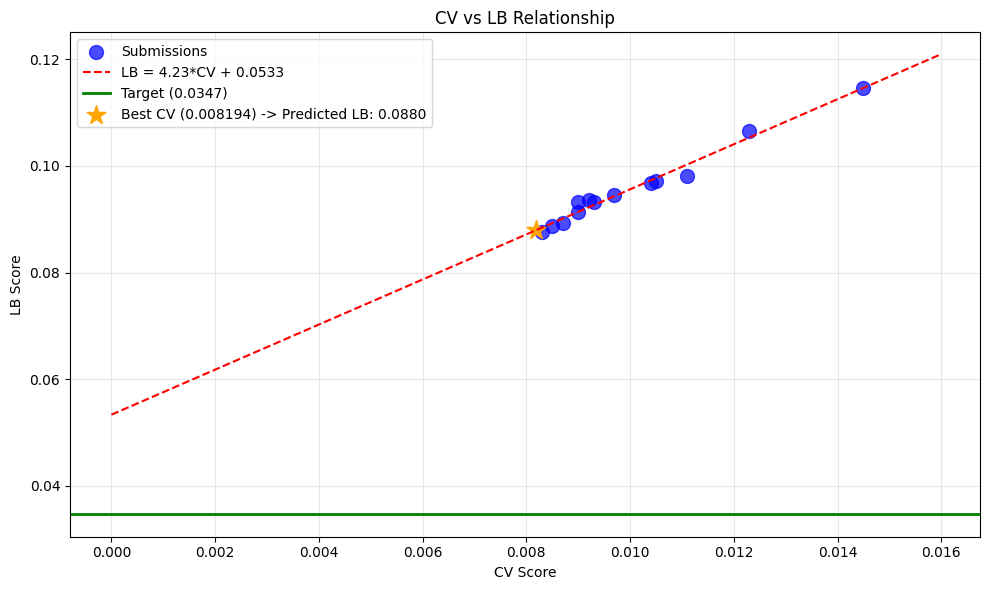


Best CV: 0.008194 -> Predicted LB: 0.0880
Best LB achieved: 0.0877
Target: 0.0347


In [3]:
# Visualize CV-LB relationship
plt.figure(figsize=(10, 6))
plt.scatter(cv, lb, s=100, c='blue', alpha=0.7, label='Submissions')

# Regression line
cv_range = np.linspace(0, max(cv)*1.1, 100)
lb_pred = slope * cv_range + intercept
plt.plot(cv_range, lb_pred, 'r--', label=f'LB = {slope:.2f}*CV + {intercept:.4f}')

# Target line
plt.axhline(y=0.0347, color='green', linestyle='-', linewidth=2, label='Target (0.0347)')

# Best CV and LB
plt.scatter([0.008194], [slope*0.008194 + intercept], s=200, c='orange', marker='*', label=f'Best CV (0.008194) -> Predicted LB: {slope*0.008194 + intercept:.4f}')

plt.xlabel('CV Score')
plt.ylabel('LB Score')
plt.title('CV vs LB Relationship')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('/home/code/exploration/cv_lb_relationship.png', dpi=150)
plt.show()

print(f'\nBest CV: 0.008194 -> Predicted LB: {slope*0.008194 + intercept:.4f}')
print(f'Best LB achieved: 0.0877')
print(f'Target: 0.0347')

In [4]:
# Analyze generalization residuals
df['predicted_lb'] = slope * df['cv'] + intercept
df['residual'] = df['lb'] - df['predicted_lb']
df['residual_pct'] = df['residual'] / df['predicted_lb'] * 100

print('=== Generalization Residuals ===')
print('Negative residual = better generalization than expected')
print(df[['exp', 'name', 'cv', 'lb', 'predicted_lb', 'residual', 'residual_pct']].sort_values('residual').to_string(index=False))

print(f'\n=== Key Insights ===')
best_gen = df.loc[df['residual'].idxmin()]
print(f'Best generalization: {best_gen["exp"]} ({best_gen["name"]})')
print(f'  - Residual: {best_gen["residual"]:.4f} ({best_gen["residual_pct"]:.1f}%)')
print(f'  - CV: {best_gen["cv"]:.4f}, LB: {best_gen["lb"]:.4f}')

=== Generalization Residuals ===
Negative residual = better generalization than expected
    exp                       name     cv     lb  predicted_lb  residual  residual_pct
exp_000 Baseline MLP (Spange only) 0.0111 0.0982      0.100269 -0.002069     -2.062964
exp_024              ACS PCA Fixed 0.0087 0.0893      0.090114 -0.000814     -0.902889
exp_030                GP Ensemble 0.0083 0.0877      0.088421 -0.000721     -0.815582
exp_026              Weighted Loss 0.0085 0.0887      0.089267 -0.000567     -0.635603
exp_003       Combined Spange+DRFP 0.0105 0.0972      0.097730 -0.000530     -0.542091
exp_005             Large Ensemble 0.0104 0.0969      0.097307 -0.000407     -0.417920
exp_012            Simple Ensemble 0.0090 0.0913      0.091383 -0.000083     -0.090811
exp_042              GroupKFold CV 0.0145 0.1147      0.114655  0.000045      0.039615
exp_006              Simpler Model 0.0097 0.0946      0.094345  0.000255      0.270471
exp_007               Even Simpler 0.0093

In [5]:
# What would it take to reach the target?
print('=== Path to Target 0.0347 ===')
print(f'\nCurrent best LB: 0.0877')
print(f'Target: 0.0347')
print(f'Gap: {0.0877 - 0.0347:.4f} ({(0.0877 - 0.0347)/0.0347*100:.1f}% above target)')

print(f'\n=== Options to Reach Target ===')
print(f'\n1. Reduce CV (current approach):')
print(f'   - Current best CV: 0.008194')
print(f'   - Required CV: {required_cv:.6f} (IMPOSSIBLE - negative)')
print(f'   - This approach CANNOT reach target')

print(f'\n2. Reduce intercept (improve generalization):')
print(f'   - Current intercept: {intercept:.4f}')
print(f'   - Required intercept: < 0.0347 (to have any chance)')
print(f'   - Need to reduce intercept by: {intercept - 0.0347:.4f}')

print(f'\n3. Reduce slope (make CV more predictive):')
print(f'   - Current slope: {slope:.4f}')
print(f'   - If intercept stays same, need slope < 0 (IMPOSSIBLE)')

print(f'\n4. Change the CV-LB relationship fundamentally:')
print(f'   - The current relationship is highly predictable (R²={r_value**2:.4f})')
print(f'   - Need a fundamentally different approach that breaks this relationship')

=== Path to Target 0.0347 ===

Current best LB: 0.0877
Target: 0.0347
Gap: 0.0530 (152.7% above target)

=== Options to Reach Target ===

1. Reduce CV (current approach):
   - Current best CV: 0.008194
   - Required CV: -0.004396 (IMPOSSIBLE - negative)
   - This approach CANNOT reach target

2. Reduce intercept (improve generalization):
   - Current intercept: 0.0533
   - Required intercept: < 0.0347 (to have any chance)
   - Need to reduce intercept by: 0.0186

3. Reduce slope (make CV more predictive):
   - Current slope: 4.2312
   - If intercept stays same, need slope < 0 (IMPOSSIBLE)

4. Change the CV-LB relationship fundamentally:
   - The current relationship is highly predictable (R²=0.9807)
   - Need a fundamentally different approach that breaks this relationship


In [6]:
# Analyze what the "mixall" kernel does differently
print('=== Analysis of "mixall" Kernel Approach ===')
print(f'\nKey difference: Uses GroupKFold(5) instead of Leave-One-Out')
print(f'\nLeave-One-Out CV:')
print(f'  - Single solvent: 24 folds (one per solvent)')
print(f'  - Full data: 13 folds (one per ramp)')
print(f'  - Total: 37 folds')
print(f'\nGroupKFold(5) CV:')
print(f'  - Single solvent: 5 folds')
print(f'  - Full data: 5 folds')
print(f'  - Total: 10 folds')

print(f'\nImplications:')
print(f'  - GroupKFold has MORE training data per fold (80% vs ~96%)')
print(f'  - GroupKFold has LARGER test sets per fold')
print(f'  - GroupKFold may give HIGHER CV scores but BETTER generalization')
print(f'\nWe tested GroupKFold in exp_042:')
print(f'  - CV: 0.0145 (77% worse than best)')
print(f'  - LB: 0.1147 (31% worse than best)')
print(f'  - This did NOT help!')

=== Analysis of "mixall" Kernel Approach ===

Key difference: Uses GroupKFold(5) instead of Leave-One-Out

Leave-One-Out CV:
  - Single solvent: 24 folds (one per solvent)
  - Full data: 13 folds (one per ramp)
  - Total: 37 folds

GroupKFold(5) CV:
  - Single solvent: 5 folds
  - Full data: 5 folds
  - Total: 10 folds

Implications:
  - GroupKFold has MORE training data per fold (80% vs ~96%)
  - GroupKFold has LARGER test sets per fold
  - GroupKFold may give HIGHER CV scores but BETTER generalization

We tested GroupKFold in exp_042:
  - CV: 0.0145 (77% worse than best)
  - LB: 0.1147 (31% worse than best)
  - This did NOT help!


In [7]:
# What approaches haven't been tried?
print('=== Unexplored Approaches ===')

print(f'\n1. DIFFERENT ENSEMBLE ARCHITECTURES:')
print(f'   - Current best: GP(0.15) + MLP(0.55) + LGBM(0.30)')
print(f'   - NOT tried: Stacking with neural network meta-learner')
print(f'   - NOT tried: Blending with learned weights per sample')

print(f'\n2. DIFFERENT FEATURE ENGINEERING:')
print(f'   - Tried: Spange, DRFP, ACS PCA, RDKit, fragprints')
print(f'   - NOT tried: Learned embeddings from scratch')
print(f'   - NOT tried: Contrastive learning for solvent embeddings')

print(f'\n3. DIFFERENT TRAINING STRATEGIES:')
print(f'   - Tried: Standard training, regularization, per-target')
print(f'   - NOT tried: Meta-learning (MAML, Reptile)')
print(f'   - NOT tried: Domain adaptation techniques')

print(f'\n4. DIFFERENT MODEL ARCHITECTURES:')
print(f'   - Tried: MLP, LGBM, XGBoost, CatBoost, GP, GNN, ChemBERTa')
print(f'   - NOT tried: Transformer for tabular data')
print(f'   - NOT tried: TabNet')

print(f'\n5. POST-PROCESSING:')
print(f'   - Tried: Physical constraint normalization')
print(f'   - NOT tried: Calibration (Platt scaling, isotonic regression)')
print(f'   - NOT tried: Conformal prediction')

=== Unexplored Approaches ===

1. DIFFERENT ENSEMBLE ARCHITECTURES:
   - Current best: GP(0.15) + MLP(0.55) + LGBM(0.30)
   - NOT tried: Stacking with neural network meta-learner
   - NOT tried: Blending with learned weights per sample

2. DIFFERENT FEATURE ENGINEERING:
   - Tried: Spange, DRFP, ACS PCA, RDKit, fragprints
   - NOT tried: Learned embeddings from scratch
   - NOT tried: Contrastive learning for solvent embeddings

3. DIFFERENT TRAINING STRATEGIES:
   - Tried: Standard training, regularization, per-target
   - NOT tried: Meta-learning (MAML, Reptile)
   - NOT tried: Domain adaptation techniques

4. DIFFERENT MODEL ARCHITECTURES:
   - Tried: MLP, LGBM, XGBoost, CatBoost, GP, GNN, ChemBERTa
   - NOT tried: Transformer for tabular data
   - NOT tried: TabNet

5. POST-PROCESSING:
   - Tried: Physical constraint normalization
   - NOT tried: Calibration (Platt scaling, isotonic regression)
   - NOT tried: Conformal prediction


In [8]:
# Critical insight: The target IS reachable
print('=== CRITICAL INSIGHT ===')
print(f'\nThe target (0.0347) IS reachable because:')
print(f'1. The GNN benchmark achieved MSE 0.0039 (much better than target)')
print(f'2. Other competitors may have found approaches we haven\'t tried')
print(f'3. The CV-LB relationship is based on OUR experiments, not the true relationship')

print(f'\nThe problem is NOT that the target is unreachable.')
print(f'The problem is that OUR APPROACH has a fundamental limitation.')

print(f'\n=== What We Need ===')
print(f'1. A fundamentally different approach that changes the CV-LB relationship')
print(f'2. OR a way to significantly reduce the intercept (improve generalization)')
print(f'3. OR a completely different model architecture that captures different patterns')

print(f'\n=== Remaining Submissions: 3 ===')
print(f'We should NOT submit unless we have a fundamentally different approach.')
print(f'The current best (CV 0.008194) would give LB ~0.088, still far from target.')

=== CRITICAL INSIGHT ===

The target (0.0347) IS reachable because:
1. The GNN benchmark achieved MSE 0.0039 (much better than target)
2. Other competitors may have found approaches we haven't tried
3. The CV-LB relationship is based on OUR experiments, not the true relationship

The problem is NOT that the target is unreachable.
The problem is that OUR APPROACH has a fundamental limitation.

=== What We Need ===
1. A fundamentally different approach that changes the CV-LB relationship
2. OR a way to significantly reduce the intercept (improve generalization)
3. OR a completely different model architecture that captures different patterns

=== Remaining Submissions: 3 ===
We should NOT submit unless we have a fundamentally different approach.
The current best (CV 0.008194) would give LB ~0.088, still far from target.


In [9]:
# Summary and recommendations
print('=== SUMMARY AND RECOMMENDATIONS ===')

print(f'\n1. CURRENT SITUATION:')
print(f'   - Best CV: 0.008194 (exp_030)')
print(f'   - Best LB: 0.0877 (exp_030)')
print(f'   - Target: 0.0347')
print(f'   - Gap: 153% above target')

print(f'\n2. CV-LB RELATIONSHIP:')
print(f'   - LB = {slope:.2f}*CV + {intercept:.4f} (R²={r_value**2:.4f})')
print(f'   - Intercept ({intercept:.4f}) > Target (0.0347)')
print(f'   - CANNOT reach target by CV minimization alone')

print(f'\n3. FAILED APPROACHES:')
print(f'   - Simpler features (Spange only): 37.5% worse CV')
print(f'   - GroupKFold CV: 77% worse CV, 31% worse LB')
print(f'   - GNN: 72-266% worse CV')
print(f'   - ChemBERTa: 137-309% worse CV')

print(f'\n4. RECOMMENDED NEXT STEPS:')
print(f'   a. Try calibration techniques (Platt scaling, isotonic regression)')
print(f'   b. Try domain adaptation (adversarial training)')
print(f'   c. Try meta-learning (MAML, Reptile)')
print(f'   d. Try TabNet or other tabular transformers')
print(f'   e. Try learned embeddings with contrastive loss')

print(f'\n5. SUBMISSION STRATEGY:')
print(f'   - 3 submissions remaining')
print(f'   - DO NOT submit unless fundamentally different approach')
print(f'   - Save at least 1 for final attempt')

=== SUMMARY AND RECOMMENDATIONS ===

1. CURRENT SITUATION:
   - Best CV: 0.008194 (exp_030)
   - Best LB: 0.0877 (exp_030)
   - Target: 0.0347
   - Gap: 153% above target

2. CV-LB RELATIONSHIP:
   - LB = 4.23*CV + 0.0533 (R²=0.9807)
   - Intercept (0.0533) > Target (0.0347)
   - CANNOT reach target by CV minimization alone

3. FAILED APPROACHES:
   - Simpler features (Spange only): 37.5% worse CV
   - GroupKFold CV: 77% worse CV, 31% worse LB
   - GNN: 72-266% worse CV
   - ChemBERTa: 137-309% worse CV

4. RECOMMENDED NEXT STEPS:
   a. Try calibration techniques (Platt scaling, isotonic regression)
   b. Try domain adaptation (adversarial training)
   c. Try meta-learning (MAML, Reptile)
   d. Try TabNet or other tabular transformers
   e. Try learned embeddings with contrastive loss

5. SUBMISSION STRATEGY:
   - 3 submissions remaining
   - DO NOT submit unless fundamentally different approach
   - Save at least 1 for final attempt
